In [4]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Background
In this project, you will use PyTorch to train neural networks for the tasks of image classification and image segemntation.

If you are not familiar with PyTorch, this [tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) guides you through how you write a training loop to train a PyTorch model.
You can basically follow the tutorial to do Part 1, and you can use the classifier model in the tutorial as a reference to build the model we describe.

The overall pipeline for training a model in PyTorch is:
- load the data
- build a model
- setup an optimizer for the model parameters
- choose a criterion (loss function)
- write a training loop that optimizers the model parameters w/ gradient descent (through the pytorch optimizer)

The main differences between part 1 and 2 would be:
- The labels (image classes *vs*. per pixel class)
- The model (in part 1, you predict a class *per image*, while in part 2 you need to predict class *per pixel*)
- The loss function

**Note: Colab allows you to use GPU, so make sure to use that to speed up training**
You can simply move everything to the GPU in PyTorch by calling `cuda()` on your model and parameters like this:

```
model = model.cuda()
data_x = data_x.cuda()
labels = labels.cuda()

```




# Part 1: Training an Image Classifier




##Overview
CIFAR10 dataset will be used to train an image classifier.

![](https://miro.medium.com/max/578/1*BCsHErqOJxmKDLQXYJR_ow.png)



##Data
Using `torchvision`, it’s extremely easy to load `CIFAR10`.

In [ ]:
## The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


images min=-1.0 max=0.8901960849761963


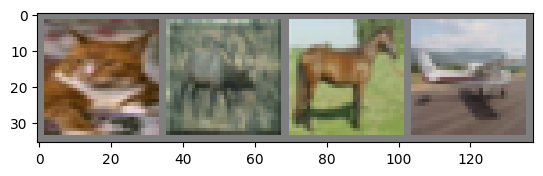

cat   deer  horse plane


In [ ]:
## Let's show some of the training images, for fun :)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
print(f"images min={images.min()} max={images.max()}")
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##Code (20 pts)

###Define a Convolutional Neural Network (10 pt)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        """
          Add layers to your neural net.
          Tutorial for reference: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
        """
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        """
          Forward pass:
            Apply layers you defined in __init__() to RGB input
            layers: Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().cuda()

###Define a Loss function and optimizer (5 pt)

Let’s use a Classification Cross-Entropy loss and SGD with momentum. (Feel free to experiment with other loss functions and optimizers to observe differences)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###Train the network (5 pts)

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
def trainning (epochs,model):
  loss_over_epochs = []
  accuracy_over_epochs = []
  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          """
            Below, please add code to perform the following:
            1. Move inputs and labels to the GPU
            2. Zero parameter gradients
            3. Pass input into model (forward pass)
            4. Calculate loss
            5. Perform backpropagation (backward pass)
          """
          # Move inputs and labels to the GPU
          inputs, labels = inputs.cuda(), labels.cuda()

          # Zero parameter gradients
          optimizer.zero_grad()

          # Pass input into model (forward pass)
          outputs = model(inputs)

          # Calculate loss
          loss = criterion(outputs, labels)

          # Perform backpropagation (backward pass)
          loss.backward()

          optimizer.step()
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
      loss_over_epochs.append(running_loss/2000)
      accuracy_over_epochs.append(test(model))

  print('Finished Training')

  ## Let’s quickly save our trained model
  PATH = './cifar_net.pth'
  torch.save(model.state_dict(), PATH)
  return loss_over_epochs, accuracy_over_epochs

###Test your network on the test data
We have trained the network over the training dataset. But we need to check if the network has learned anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

In [ ]:
def test(model):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # no gradients needed during test phase
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to('cuda')
          labels = labels.to('cuda')
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  average_accuracy = 0
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
      average_accuracy += accuracy
  return average_accuracy/len(correct_pred.items())

## Write-up (5 pt)

*   Plot loss over epochs
*   Plot accuracy over epochs

In [ ]:
loss_over_epochs, accuracy_over_epochs = trainning(10,net)

[1,  2000] loss: 2.192
[1,  4000] loss: 1.859
[1,  6000] loss: 1.700
[1,  8000] loss: 1.597
[1, 10000] loss: 1.529
[1, 12000] loss: 1.462
Accuracy for class: plane is 49.6 %
Accuracy for class: car   is 67.4 %
Accuracy for class: bird  is 34.0 %
Accuracy for class: cat   is 16.2 %
Accuracy for class: deer  is 31.1 %
Accuracy for class: dog   is 51.2 %
Accuracy for class: frog  is 69.6 %
Accuracy for class: horse is 61.5 %
Accuracy for class: ship  is 72.2 %
Accuracy for class: truck is 34.7 %
[2,  2000] loss: 1.401
[2,  4000] loss: 1.384
[2,  6000] loss: 1.359
[2,  8000] loss: 1.341
[2, 10000] loss: 1.288
[2, 12000] loss: 1.319
Accuracy for class: plane is 68.1 %
Accuracy for class: car   is 77.5 %
Accuracy for class: bird  is 36.7 %
Accuracy for class: cat   is 39.9 %
Accuracy for class: deer  is 37.5 %
Accuracy for class: dog   is 36.2 %
Accuracy for class: frog  is 75.3 %
Accuracy for class: horse is 63.1 %
Accuracy for class: ship  is 61.0 %
Accuracy for class: truck is 55.4 %
[3, 

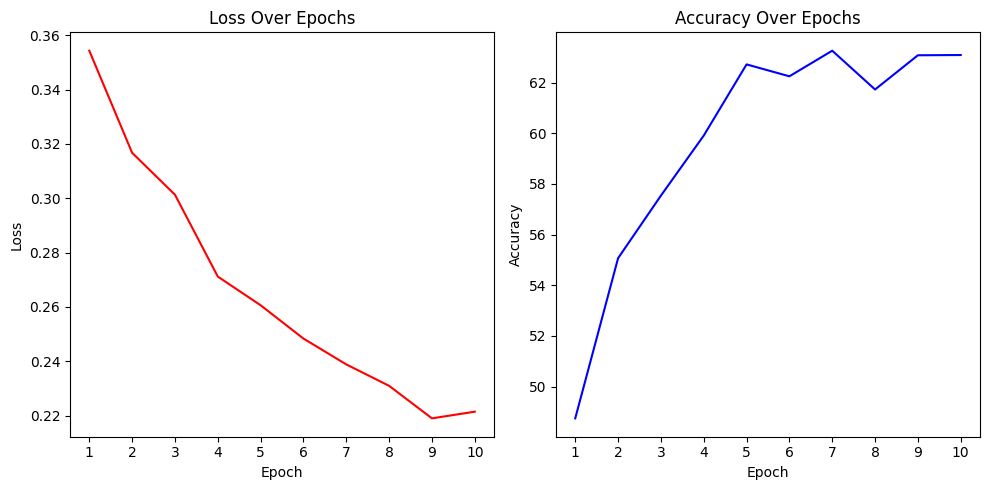

In [ ]:
epochs = list(range(1, len(loss_over_epochs) + 1))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_over_epochs, color='r')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1,len(loss_over_epochs) + 1))

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_over_epochs, color='b')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1,len(loss_over_epochs) + 1))

plt.tight_layout()
plt.show()

## Extra Credits (5 pt)
Run VGG with pre-trained weights in this [colab](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_vgg.ipynb#scrollTo=daily-wayne). Test any two images of your choice to your model and to VGG model and show accuracy (images must include objects from CIFAR10 classes). Discuss which model performs better and why.

My perform better. I think it probably because my model is easy and doesn't take a lot of resource to train it. While VGG is very deep the trainning process is very big. And as my epochs is relatively small, my model perform better in this kind of easy task.

In [ ]:
def test_demo(model):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # no gradients needed during test phase
  with torch.no_grad():
      count = 0
      for data in testloader:
          images, labels = data
          images = images.to('cuda')
          labels = labels.to('cuda')
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          count += 1
          if count == 2:
              break
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                print("correct")
              else:
                print("wrong")


model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
model = model.cuda()
trainning(4,model)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[1,  2000] loss: 2.711
[1,  4000] loss: 2.703
[1,  6000] loss: 2.710
[1,  8000] loss: 2.704
[1, 10000] loss: 2.716
[1, 12000] loss: 2.727
Accuracy for class: plane is 11.4 %
Accuracy for class: car   is 4.6 %
Accuracy for class: bird  is 6.3 %
Accuracy for class: cat   is 16.8 %
Accuracy for class: deer  is 2.8 %
Accuracy for class: dog   is 12.9 %
Accuracy for class: frog  is 12.4 %
Accuracy for class: horse is 5.1 %
Accuracy for class: ship  is 9.6 %
Accuracy for class: truck is 5.6 %
[2,  2000] loss: 2.705
[2,  4000] loss: 2.706
[2,  6000] loss: 2.719
[2,  8000] loss: 2.718
[2, 10000] loss: 2.732
[2, 12000] loss: 2.708
Accuracy for class: plane is 12.0 %
Accuracy for class: car   is 5.7 %
Accuracy for class: bird  is 6.4 %
Accuracy for class: cat   is 19.4 %
Accuracy for class: deer  is 3.7 %
Accuracy for class: dog   is 13.0 %
Accuracy for class: frog  is 12.0 %
Accuracy for class: horse is 2.5 %
Accuracy for class: ship  is 9.8 %
Accuracy for class: truck is 8.3 %
[3,  2000] loss:

([0.6781216223835945,
  0.6838121816515923,
  0.6780606343150138,
  0.6829305359125137],
 [8.749999999999998, 9.28, 8.9, 9.110000000000001])

In [ ]:
print("Prediction result for my model is:")
a = test_demo(net)
print("Prediction result for VGG model is:")
b = test_demo(model)

Prediction result for my model is:
wrong
wrong
correct
correct
Prediction result for VGG model is:
wrong
wrong
wrong
wrong


# Part 2: Semantic Segmentation

## Overview
**Semantic Segmentation** is an image analysis task in which we **classify** ***each pixel*** in the image into a class.

Let's say we have the following image:

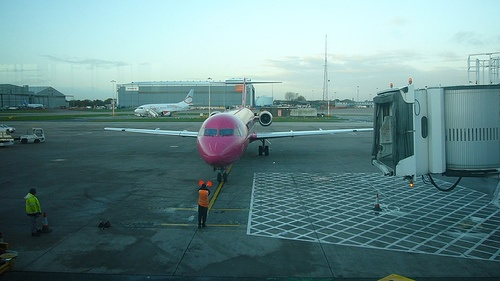

Given the above image its semantically segmented image would be the following:

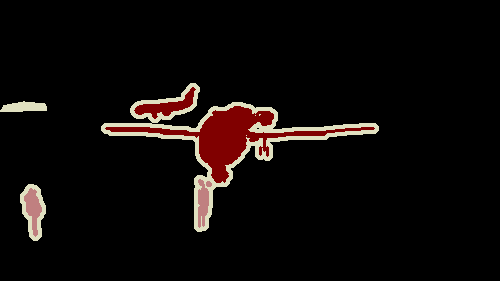

As you can see, ***each pixel*** in the image is classified to its respective class.


## Resources
* **Refer to original paper FCNet for implementation details**: https://arxiv.org/abs/1411.4038
* Figures of FCNet Structure: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
* PyTorch tutorial for image segmentation: https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f

## Data

WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.

In [5]:
import os
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'

def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path

  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")

get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

"""Various RGB palettes for coloring segmentation labels."""

# Color channels in the segmentation maps in the dataset
VOC_COLORMAP = [
    [0, 0, 0],
    [224, 224, 192],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

# Categories that correspond to each color above
VOC_CLASSES = [
    "background",
    "edge",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

## Code (25 pt)

### 1. Implement dataset class for training and validation (5 pt)

In [7]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class VocDataset(Dataset):
  def __init__(self, dir, color_map):
    self.root = os.path.join(dir,'VOCdevkit/VOC2007')
    self.images_dir = os.path.join(self.root,'JPEGImages')
    self.target_dir = os.path.join(self.root,'SegmentationClass') # ground truth?
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in open(file_list, "r")]
    self.color_map = color_map

  def __len__(self):
    return len(self.files)

  def colors_to_seg_map(self, seg_RGB):
    """
      Convert [R, G, B] color channels of RGB segmentation maps (from dataset)
      to binary segmentation map of shape (H, W), where n_classes
      is the number of distinct classes/colors present in  RGB segmentation map.

      The diagram below may provide more insight on how seg_map should be structured.
    """

    h, w, _ = seg_RGB.shape
    n_classes = len(self.color_map)
    class_map = np.zeros((h, w), dtype=int)

    for idx, color in enumerate(self.color_map):
        mask = (seg_RGB == np.array(color)).all(axis=-1)
        class_map[mask] = idx + 1  # Assign class index (1-based index)


    # print("Final class_map type:", type(class_map))
    return torch.from_numpy(class_map)


  def __getitem__(self, index):
    """
      1. Read in RGB image and RGB segmentation map.
      2. Convert RGB segmentation map to binary segmentation map of shape (n_classes, H, W)
    """
    # YOUR CODE HERE
    file_name = self.files[index]
    img_path = os.path.join(self.images_dir, file_name + '.jpg')
    target_path = os.path.join(self.target_dir, file_name + '.png')

    # Read in RGB image and RGB segmentation map
    image = Image.open(img_path).convert('RGB')
    seg_RGB = np.array(Image.open(target_path).convert('RGB'))

    # Convert RGB segmentation map to binary segmentation map
    seg_map = self.colors_to_seg_map(seg_RGB)

    # print("1,",type(image))
    # print("2,",type(seg_map))
    # Convert to PyTorch tensors
    transform1 = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.48235, 0.45882, 0.40784], std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098])
            ])
    image = transform1(image)
    # print("3,",type(image),image.shape)
    transform2 = transforms.Compose([
            transforms.CenterCrop(224),
            ])
    seg_map = transform2(seg_map)
    # print("4,",type(seg_map),seg_map.shape)
    return image, seg_map

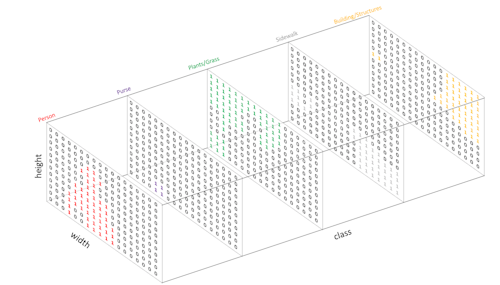

###2. Define model and training loop (15 pt)

#### Build the FCN-32 model

In [14]:
class FCN32(torch.nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    # Pretrained VGG-16 features (first half of NN)
    vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
    features = list(vgg16.features.children())
    self.vgg_features = nn.Sequential(*features)
    self.n_class = n_classes

    """
      Perform upsampling via deconvolution operations
    """
    # YOUR CODE HERE
    self.encoder = torch.nn.Sequential(*features)
    self.encoder_classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7),  # Fully conv. layer replacing fc6
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, kernel_size=1),  # Fully conv. layer replacing fc7
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(4096, len(self.n_class), kernel_size=1),  # A 1x1 conv to get class scores
            nn.ConvTranspose2d(22, 22, 224, stride=32)
        )


  def forward(self, x):
    """
      Similar to what you did in Part 1, apply layers you defined in __init__()
      to RGB input to perform the forward pass.
    """
    # YOUR CODE HERE
    x = self.encoder(x)
    x = self.encoder_classifier(x)

    return x

model = FCN32(n_classes = VOC_CLASSES).cuda()

#### Training loop for the semantic segmentation model

Hint: you will need to *center crop* the input data into size 224x224 before passing into your model. Check out [`torchvision.transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html).

In [15]:
import torch.optim as optim

batch_size = 4

trainset = VocDataset('./',VOC_COLORMAP)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


criterion = torch.nn.CrossEntropyLoss() # YOUR CODE HERE: Add loss function (pixel-wise loss)
optimizer = optim.Adam(model.parameters(), lr=0.001) # YOUR CODE HERE: Add optimizer

epochs = 5
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    """
      Implement the training loop (similar to what you've done in Part 1)
    """
    for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          if len(inputs.shape)!= 3:
            continue
          inputs, labels = inputs.cuda(), labels.cuda()
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          if i % 5 == 4:
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
              running_loss = 0.0

print('Finished Training')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished Training


### 3. Inference for semantic segmentation (5 pt)

Perform inference by running your trained model on the testing data.

*   Display the results of your FCN-32 model
      *   Visualize 1) the input image and 2) the output segmentation map
*   Report mean IoU as the evaluation metric

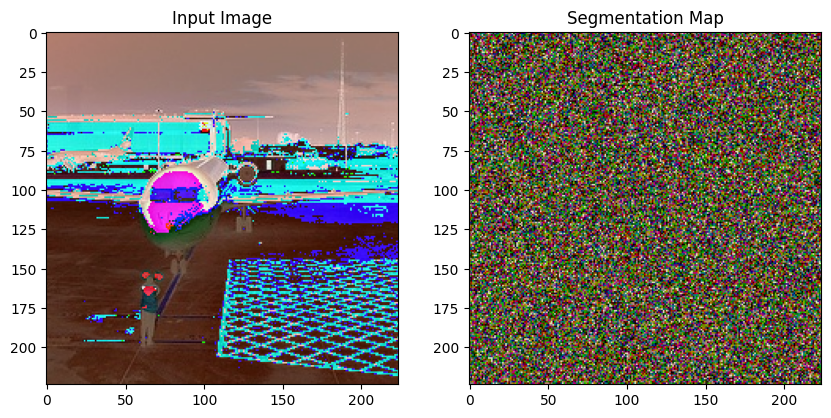

In [31]:
model.eval()

test_dataset = VocDataset('./',VOC_COLORMAP)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def decode_segmap(image, nc=22):

  label_colors = np.array([(0, 0, 0),(224, 224, 192),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

def visualize_segmentation(image, segmentation):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(transforms.ToPILImage()(image.cpu()))
    plt.title('Input Image')
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation)
    plt.title('Segmentation Map')
    plt.show()

# Run the model on the test data

for image, _ in test_loader:
    image = image.cuda()
    with torch.no_grad():
        output = model(image)

    prediction = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    segmentation = decode_segmap(prediction)
    visualize_segmentation(image.squeeze(), segmentation)
    break
